In [1]:
import pandas as pd
import numpy as np
import rebound
import matplotlib.pyplot as plt
import reboundx
from matplotlib import colors
from rebound.interruptible_pool import InterruptiblePool

In [2]:
def simulation(param):
    P1, P2 = param
    ecc1, ecc0, ecc2 = 0.04,0.04,0.09
    mu1, mu2 = 36e-6, 28e-6
    pomega1, pomega0, pomega2 = 0,0,np.pi
    P_0 = 0.05

    # start simulation
    sim = rebound.Simulation()
    sim.units = ('yr', 'AU', 'Msun')

    # add star, planet 1, planet 2
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)
    
    # add test particle
    sim.add(P=P_0, e=ecc0, pomega=pomega0)
    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    
    # add central force
    rebx = reboundx.Extras(sim)
    cf = rebx.load_force("central_force")
    rebx.add_force(cf)
    ps[0].params["gammacentral"] = -3
    ps[0].params["Acentral"] = -2e-4
    
    time = np.logspace(0,6,num=100)*P_0
    for T in time:
        try:
            sim.integrate(T, exact_finish_time=0)
        except rebound.Collision:
            return sim.t
    return 1e7*P_0

In [3]:
Ngrid_x = 200
Ngrid_y = 200
P_0 = 0.05

r10 = np.linspace(0.65,0.76,Ngrid_x)
r20 = np.linspace(1.3,1.55,Ngrid_y)
parameters = [[P_0*x, P_0*y] for x in r10 for y in r20]

In [4]:
from datetime import datetime
with open('log.txt', 'a') as file:
    file.write('Collision time with central force (ecc=(0.04,0.04,0.09), pomega=(0,0,pi), 200-by-200), started at %s\n' %datetime.now())
    file.close()

In [ ]:
pool = InterruptiblePool()
results = pool.map(simulation,parameters)
np.savetxt("collision_time_with_force.csv", results, delimiter=",")

In [ ]:
with open('log.txt', 'a') as file:
    file.write('Collision time with central force ended at %s\n' %datetime.now())
    file.close()

In [9]:
def rescale(results):
    time_rescaled = np.zeros(len(results))
    for i, value in enumerate(results):
        time_rescaled[i] = round(np.log10(value/0.05))
    return time_rescaled

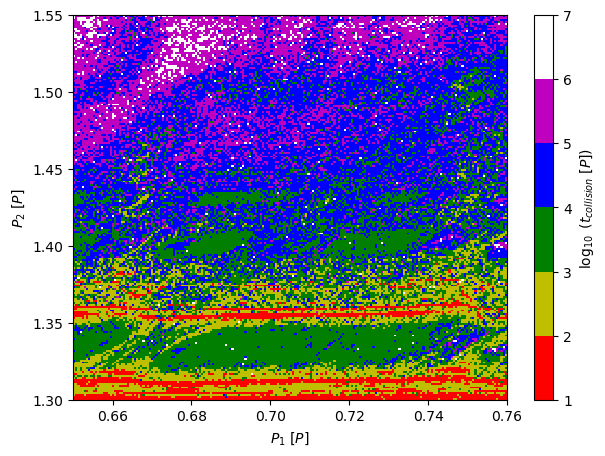

In [10]:
results_rescaled = rescale(results)
results2d = np.array(results_rescaled).reshape(Ngrid_y,Ngrid_x)

fig = plt.figure(figsize=(7,5))
ax = plt.subplot(111)
extent = [min(r10),max(r10),min(r20),max(r20)]
ax.set_xlim(extent[0],extent[1])
ax.set_xlabel(r"$P_1$ [$P$]")
ax.set_ylim(extent[2],extent[3])
ax.set_ylabel(r"$P_2$ [$P$]")
im = ax.imshow(results2d.transpose(), interpolation="none", vmin=1, vmax=7, cmap=colors.ListedColormap(['r','y','g','b','m','w']), origin="lower", aspect='auto', extent=extent)
cb = plt.colorbar(im, ax=ax)
cb.set_label(r"$\log_{10}$ ($t_{collision}$ [$P$])")